In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이터 세트 로드
boston = load_boston()

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함.
bostonDF['PRICE'] = boston.target
print("Boston 데이터 세트 크기 :", bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [2]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


데이터 세트 피처의 Null 값은 없으며 모두 float 형이다.

## 각 칼럼이 회귀 결과에 미치는 영향이 어느 정도인지 시각화

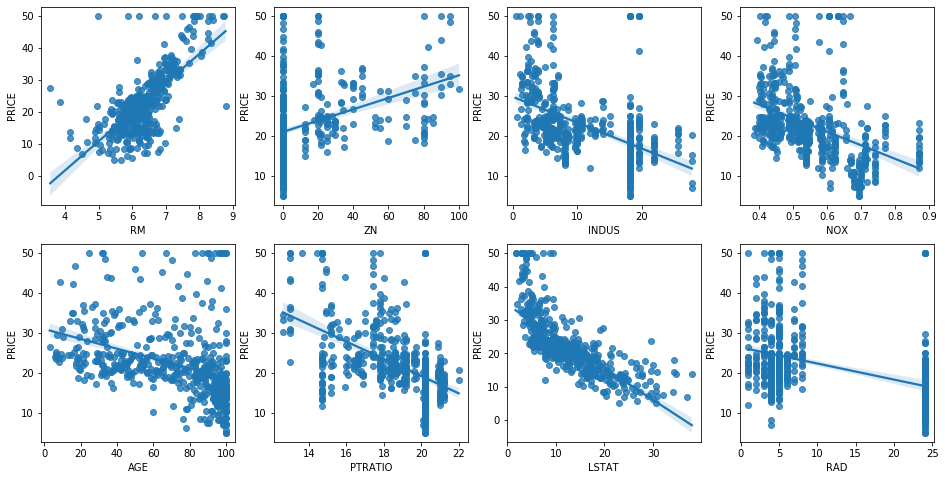

In [3]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16, 8), ncols = 4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO','LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

## 주택 가격의 회귀 모델

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.3, random_state = 37)

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print("MSE : {0:.3f}, RMSE : {1:.3f}".format(mse, rmse))
print("Variance Score : {0:.3f}".format(r2_score(y_test, y_preds)))

MSE : 34.661, RMSE : 5.887
Variance Score : 0.676


In [5]:
print("절편 값:", lr.intercept_)
print("회귀 계수값:", np.round(lr.coef_,1 ))

절편 값: 38.025761828198526
회귀 계수값: [ -0.1   0.   -0.    3.4 -17.    3.5  -0.   -1.3   0.3  -0.   -1.    0.
  -0.5]


어떤 피처가 어떤 회귀 계수를 가질지 보여주고 정렬

In [6]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해서 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending=False)

RM          3.5
CHAS        3.4
RAD         0.3
B           0.0
TAX        -0.0
AGE        -0.0
INDUS      -0.0
ZN          0.0
CRIM       -0.1
LSTAT      -0.5
PTRATIO    -1.0
DIS        -1.3
NOX       -17.0
dtype: float64

## 5개의 폴드 세트에서 cross_val_score를 이용해 교차 검증을 통한 MSE, RMSE

In [7]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis = 1)
lr = LinearRegression()

# cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print(" 5 folds 의 개별 Negative MSE scores: ", np.round(neg_mse_scores, 2))
print(" 5 folds 의 개별 RMSE scores : ", np.round(rmse_scores, 2))
print(" 5 folds 의 평균 RMSE : {0:.3f}".format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829


## 다항회귀

In [8]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# 다항식으로 변환한 단항식 생성, [[0, 1], [2, 3]]의 2X2 행렬 생성
X = np.arange(4).reshape(2, 2)
print("일차 단항식 계수 피처:\n", X)

# degree = 2인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용해 변환
poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print("변환된 2차 다항식 계수 피처:\n", poly_ftr)

일차 단항식 계수 피처:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 피처:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


## 3차 다항회귀

결정 함수 식은  y=1 + 2*x_1 + 3*x_1^2 + 4*x_2^3

In [9]:
def polynomial_func(X):
    y = 1 + 2*X[:, 0] + 3*X[:, 0]**2 + 4*X[:,1]**3
    return y

X = np.arange(4).reshape(2, 2)
print("일차 단항식 계수 feature: \n", X)
y = polynomial_func(X)
print("삼차 다항식 결정값: \n", y)

일차 단항식 계수 feature: 
 [[0 1]
 [2 3]]
삼차 다항식 결정값: 
 [  5 125]


In [10]:
# 3차 다항식 변환
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)
print("3차 다항식 계수 feature: \n", poly_ftr)

# Linear Regression에 3차 다항식 계수 feature와 3차 다항식 결정ㅈ값으로 학습 후 회귀 계수 확인
model = LinearRegression()
model.fit(poly_ftr, y)
print("Polynomial 회귀 계수\n", np.round(model.coef_, 2))
print("Polynomial 회귀 Shape :", model.coef_.shape)

3차 다항식 계수 feature: 
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 Shape : (10,)


## Pipeline 객체를 이용한 다항 회귀

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

def polynomial_func(X):
    y = 1 + 2*X[:, 0] + 3*X[:, 0]**2 + 4*X[:,1]**3
    return y

# Pipeline 객체로 Streamline하게 Polynomial Feature 변환과 Linear Regression을 연결
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                 ('linear', LinearRegression())])

X = np.arange(4).reshape(2, 2)
y = polynomial_func(X)

model = model.fit(X, y)

print("Polynomial 회귀 계수\n", np.round(model.named_steps['linear'].coef_, 2))

Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


## 다항 회귀를 이용한 과소적합 및 과적합 이해

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

# 임의의 값으로 구성된 X값에 코사인 변환 값을 반환.
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# X는 0부터 1까지 30개의 임의의 값을 순서대로 샘플링한 데이터입니다.
np.random.seed(37)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

# y 값은 코사인 기반의 true_fun()에서 약간의 노이즈 변동 값을 더한 값입니다.
y = true_fun(X) + np.random.randn(n_samples) * 0.1

## 본격적인 그래프


Degree 1 회귀 계수는 [-1.65] 입니다.
Degree 1 MSE 는 0.34329648349424824 입니다.

Degree 4 회귀 계수는 [  2.49 -26.08  36.6  -13.93] 입니다.
Degree 4 MSE 는 0.016055716281232264 입니다.

Degree 15 회귀 계수는 [-4.08065000e+03  1.09317000e+05 -1.64488840e+06  1.57038124e+07
 -1.01790486e+08  4.67075849e+08 -1.55750663e+09  3.83162661e+09
 -6.99458320e+09  9.44329148e+09 -9.29807774e+09  6.48607899e+09
 -3.03539000e+09  8.54416996e+08 -1.09306091e+08] 입니다.
Degree 15 MSE 는 106713.7191985761 입니다.


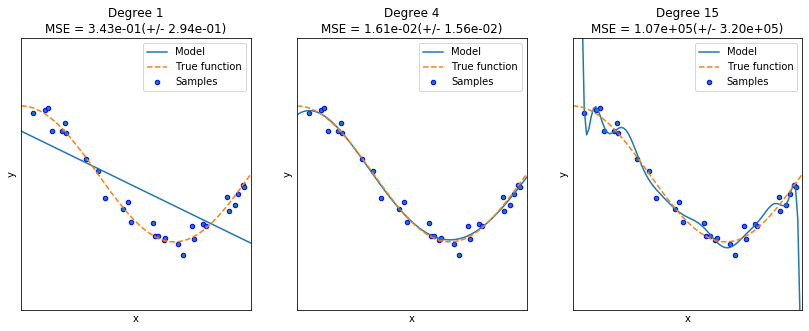

In [13]:
plt.figure(figsize = (14, 5))
degrees = [1, 4 ,15]

# 다항 회귀의 차수(degree)를 1, 4, 15로 각각 변화시키면서 비교합니다.
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i+1)
    plt.setp(ax, xticks=(), yticks=())
    
    # 개별 degree별로 Polynomial 변환합니다.
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias = False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                       ("linear_regression", linear_regression)])
    pipeline.fit(X.reshape(-1, 1), y)
    
    # 교차 검증으로 다항 회귀를 평가합니다.
    scores = cross_val_score(pipeline, X.reshape(-1, 1), y, scoring="neg_mean_squared_error", cv = 10)
    # Pipeline을 구성하는 세부 객체를 접근하는 named_steps['객체명']을 이용해 회귀계수 추출
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print("\nDegree {0} 회귀 계수는 {1} 입니다.".format(degrees[i], np.round(coefficients,2)))
    print("Degree {0} MSE 는 {1} 입니다.".format(degrees[i], -1*np.mean(scores)))
    
    # 0부터 1까지 테스트 데이터 세트를 100개로 나눠 예측을 수행합니다.
    # 테스트 데이터 세트에 회귀 예측을 수행하고 예측 곡선과 실제 곡선을 그려서 비교합니다.
    X_test = np.linspace(0, 1, 100)
    # 예측값 곡선
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    #실제 값 곡선
    plt.plot(X_test, true_fun(X_test), '--', label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label='Samples')
    
    plt.xlabel("x"); plt.ylabel("y"); plt.xlim((0, 1)); plt.ylim((-2, 2)); plt.legend(loc='best')
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))

plt.show()